In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam, SGD, Adadelta
from tensorflow.keras.applications import InceptionV3
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.callbacks import EarlyStopping
import cv2
import random
import seaborn as sns
import os


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
"""
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
"""
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

"\nimport os\nfor dirname, _, filenames in os.walk('/kaggle/input'):\n    for filename in filenames:\n        print(os.path.join(dirname, filename))\n"

In [3]:
#data augmentation
train_data = ImageDataGenerator(
    rescale = 1./255,
    featurewise_center = False,
    featurewise_std_normalization = False,
    rotation_range = 20,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    zoom_range = .1,
    horizontal_flip = True
)
test_data = ImageDataGenerator(rescale = 1./255)

In [4]:
X_train_gen = train_data.flow_from_directory(
    "/kaggle/input/fer2013effi/train/train",
    target_size = (75, 75),
    batch_size = 64,
    class_mode = "categorical"
)
X_val = test_data.flow_from_directory(
    "/kaggle/input/fer2013effi/test/test",
    target_size = (75, 75),
    batch_size = 64,
    class_mode = "categorical"
)

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [5]:
from sklearn.utils import class_weight
from keras.callbacks import ModelCheckpoint

class_weights = class_weight.compute_class_weight(
    class_weight = "balanced",
    classes = np.unique(X_train_gen.classes),
    y = X_train_gen.classes)
num_classes = 7
keys = range(num_classes)
values = class_weights.copy()
class_weights = dict(zip(keys, values))
print(class_weights)

{0: 1.0266046844269623, 1: 9.406618610747051, 2: 1.0010460615781582, 3: 0.5684387684387684, 4: 0.8260394187886635, 5: 0.8491274770777877, 6: 1.293372978330405}


In [6]:
#InceptionV3
base_model = InceptionV3(
    include_top = False,
    weights = None,
    input_shape = (75, 75, 3))
for layer in base_model.layers[:10]:
    layer.trainable = False

In [7]:
base_model.load_weights("/kaggle/input/inception/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5")

In [8]:
model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(units = 64, activation = "relu"))
model.add(Dropout(0.5)) #0.5
model.add(Dense(units = 7, activation = "softmax"))

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 1, 1, 2048)        21802784  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 64)                131136    
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 7)                 455       
                                                                 
Total params: 21,934,375
Trainable params: 21,871,303
Non-trainable params: 63,072
_________________________________________________________________


In [10]:
early_stop = EarlyStopping(monitor = "val_acc", mode = "max", patience = 5, restore_best_weights = True)

In [11]:
optimizer_1 = SGD(learning_rate = 0.01) #learning_rate = 0.01
model.compile(optimizer = optimizer_1, loss = "categorical_crossentropy", metrics = ["acc"])

In [12]:
history = model.fit(
    X_train_gen,
    epochs = 70,
    verbose = 1,
    callbacks = early_stop,
    class_weight = class_weights,
    validation_data = X_val
)

Epoch 1/70
449/449 [==============================] - 193s 369ms/step - loss: 1.9242 - acc: 0.1958 - val_loss: 1.8566 - val_acc: 0.2740
Epoch 2/70
449/449 [==============================] - 100s 223ms/step - loss: 1.7908 - acc: 0.2871 - val_loss: 1.6498 - val_acc: 0.3564
Epoch 3/70
449/449 [==============================] - 103s 230ms/step - loss: 1.6684 - acc: 0.3410 - val_loss: 1.5600 - val_acc: 0.4133
Epoch 4/70
449/449 [==============================] - 100s 223ms/step - loss: 1.5474 - acc: 0.4031 - val_loss: 1.4010 - val_acc: 0.4723
Epoch 5/70
449/449 [==============================] - 101s 225ms/step - loss: 1.4513 - acc: 0.4399 - val_loss: 1.3683 - val_acc: 0.4850
Epoch 6/70
449/449 [==============================] - 102s 228ms/step - loss: 1.3804 - acc: 0.4655 - val_loss: 1.3020 - val_acc: 0.5045
Epoch 7/70
449/449 [==============================] - 102s 226ms/step - loss: 1.3479 - acc: 0.4780 - val_loss: 1.2688 - val_acc: 0.5208
Epoch 8/70
449/449 [============================

In [29]:
from tensorflow import keras
model.save("/kaggle/working/inceptionv3_easy_stop")

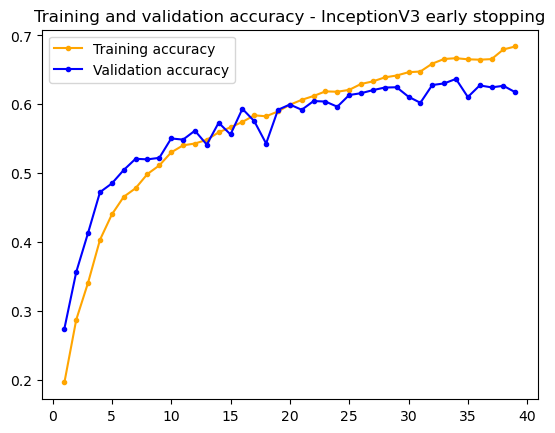

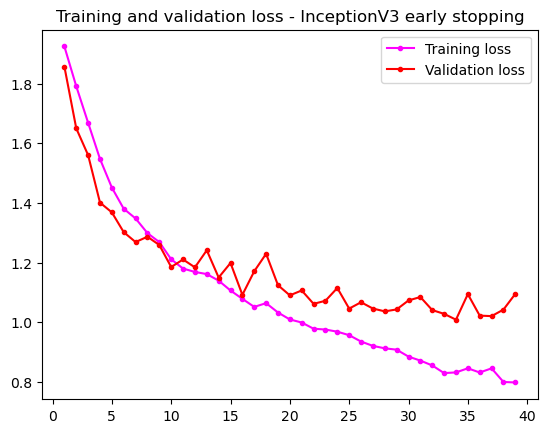

In [30]:
#history
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.title('Training and validation accuracy - InceptionV3 early stopping')
plt.plot(epochs, acc, 'orange', marker = '.', label = 'Training accuracy')
plt.plot(epochs, val_acc, 'blue', marker = '.', label = 'Validation accuracy')
plt.legend()

plt.figure()
plt.title('Training and validation loss - InceptionV3 early stopping')
plt.plot(epochs, loss, 'magenta', marker = '.', label = 'Training loss')
plt.plot(epochs, val_loss, 'red', marker = '.', label = 'Validation loss')
plt.legend()
plt.show()

In [22]:
model_inception = keras.models.load_model('/kaggle/working/inceptionv3_easy')

In [14]:
test_data = []
test_data_dir = "/kaggle/input/ferplus/test"
categories = ["angry", "disgust", "fear", "happy", "neutral", "sad", "surprise"]
def create_test_data():
    for cat in categories:
        path = os.path.join(test_data_dir, cat)
        class_num = categories.index(cat)
        for img in os.listdir(path):
            img_array = cv2.imread(os.path.join(path, img))
            new_array = cv2.resize(img_array, (75, 75))
            test_data.append([new_array, class_num])

In [15]:
create_test_data()

In [16]:
random.shuffle(test_data)
X_test = []
y_test = []
for features, labels in test_data:
    X_test.append(features)
    y_test.append(labels)
X_test = np.array(X_test).reshape(7048, 75, 75, 3)
y_test = np.array(y_test)

In [17]:
X_test = X_test/255.0

221/221 [==============================] - 6s 19ms/step


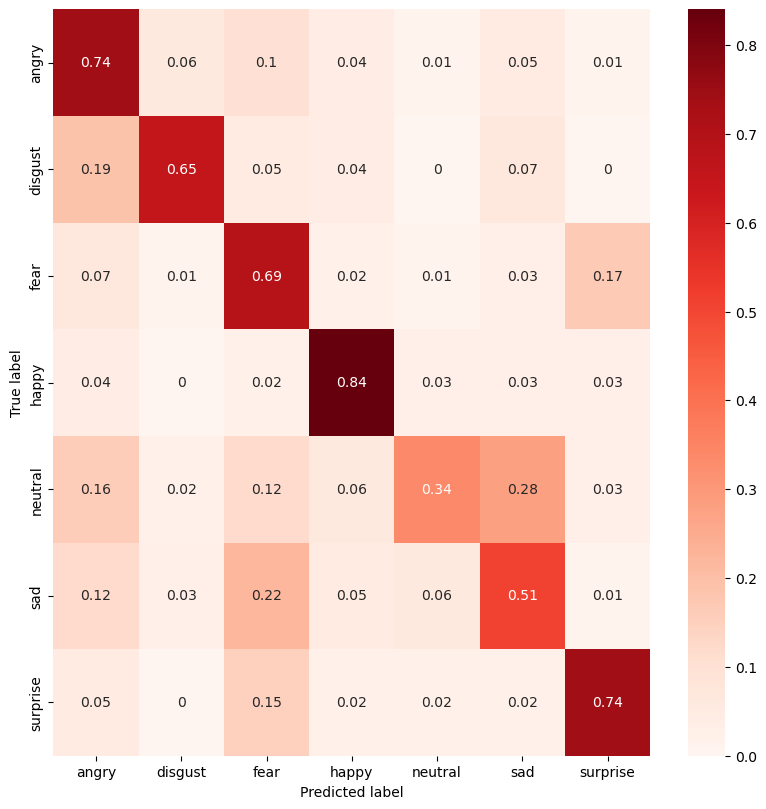

In [18]:
y_predict = model.predict(X_test)
y_true = y_test
res = tf.math.confusion_matrix(y_true, y_predict.argmax(axis=1)).numpy()
class_names = ["angry", "disgust", "fear", "happy", "neutral", "sad", "surprise"]
con_mat_norm = np.around(res.astype('float')/res.sum(axis=1)[:, np.newaxis], decimals = 2)
con_mat_df = pd.DataFrame(con_mat_norm, index = class_names, columns = class_names)

figure = plt.figure(figsize = (8,8))
sns.heatmap(con_mat_df, annot = True, cmap = plt.cm.Reds)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
#plt.savefig("/kaggle/working/confusion_matrix_vgg19_1.png")
plt.show()

In [19]:
#model evaluation
y_test = tf.keras.utils.to_categorical(y_test, num_classes = 7)
model.evaluate(X_test, y_test)

221/221 [==============================] - 4s 18ms/step - loss: 1.2318 - acc: 0.5885


[1.231757640838623, 0.588535726070404]

In [20]:
#raf-db için create data
raf_db = []
raf_db_test = "/kaggle/input/raf-db-inception/validation"
def create_test_data():
    for cat in categories:
        path = os.path.join(raf_db_test, cat)
        class_num = categories.index(cat)
        for img in os.listdir(path):
            img_array = cv2.imread(os.path.join(path, img))
            new_array = cv2.resize(img_array, (75, 75))
            raf_db.append([new_array, class_num])

In [21]:
create_test_data()

In [22]:
random.shuffle(raf_db)
X_test_raf = []
y_test_raf = []
for features, labels in raf_db:
    X_test_raf.append(features)
    y_test_raf.append(labels)
X_test_raf = np.array(X_test_raf).reshape(7066, 75, 75, 3)
y_test_raf = np.array(y_test_raf)

In [23]:
X_test_raf = X_test_raf/255.0

221/221 [==============================] - 4s 20ms/step


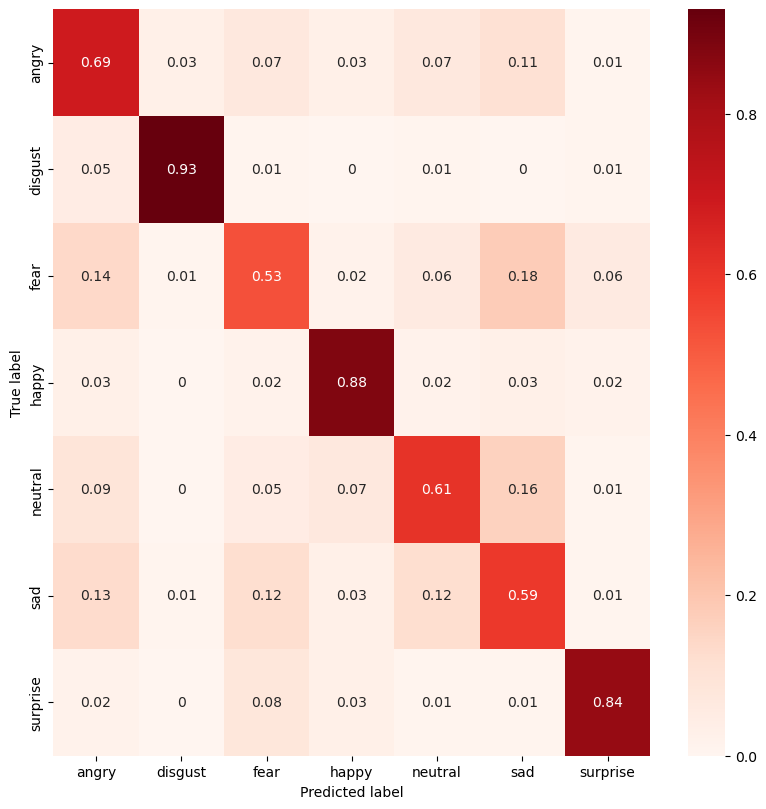

In [24]:
y_predict = model.predict(X_test_raf)
y_true = y_test_raf
res = tf.math.confusion_matrix(y_true, y_predict.argmax(axis = 1)).numpy()
class_names = ["angry", "disgust", "fear", "happy", "neutral", "sad", "surprise"]
con_mat_norm = np.around(res.astype('float')/res.sum(axis = 1)[:, np.newaxis], decimals = 2)
con_mat_df = pd.DataFrame(con_mat_norm, index = class_names, columns = class_names)

figure = plt.figure(figsize = (8,8))
sns.heatmap(con_mat_df, annot = True, cmap = plt.cm.Reds)
plt.tight_layout()
plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.show()

In [25]:
y_test_raf = tf.keras.utils.to_categorical(y_test_raf, num_classes = 7)
model.evaluate(X_test_raf, y_test_raf)

221/221 [==============================] - 4s 18ms/step - loss: 0.8087 - acc: 0.7049


[0.8086934685707092, 0.704925000667572]

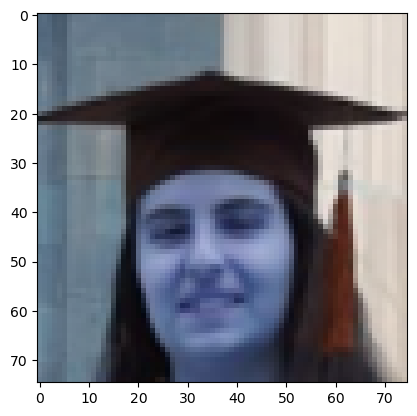

In [26]:
image = cv2.imread("/kaggle/input/image-sample/graduation_two.png")
image = cv2.resize(image, (75, 75))
plt.imshow(image)

In [27]:
dict_label = {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Neutral', 5: 'Sad', 6: 'Surprise'}
test_img = np.expand_dims(image, axis = 0)
test_img = test_img.reshape(1, 75, 75, 3)

In [28]:
result = model.predict(test_img)
result = list(result[0])
img_index = result.index(max(result))
print(dict_label[img_index])

1/1 [==============================] - 2s 2s/step
Surprise
